In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import sys
sys.path.append("../../../")
import src

from src.core.control import AfPrecisionControl
from src.core.control import CoupledStorageConfig

from src.core.dimensionless import WavevectorScale

from src.core.media import TwoBeamPhotorefractiveCrystal
from src.core.eq_coefs import CoupledPhotorefractiveCoefs
from src.core.mesh import Mesh2D
from src.core.beams import TwoBeams

from src.fields import NotebookAfCoupledSimulation2D
from src.fields import LatticeGaussianCoupledConfig

from src.fields.landscapes.lattices.moire_lattices import double_square
from src.simulators.nls_2d.coupled_eqs.split_step import split_step_solver

from src.simulators.nls_2d.coupled_eqs import CoupledSimulationBox

In [3]:
periodic_storage = CoupledStorageConfig(directory = "./Data/Periodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

aperiodic_storage = CoupledStorageConfig(directory = "./Data/Aperiodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

In [4]:
precision = "double"

periodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=periodic_storage,
                                       )

aperiodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=aperiodic_storage,
                                       )

In [5]:
a = 1e9 * 1e6
b = (1e6)**2

simulation_config = {"Nx": 1024,
                     "Ny": 1024,
                     "Nz": 200,
                     "lx": 2e-3,
                     "ly": 2e-3,
                     "lz": 20e-3,
                     }

periodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 235e-12,
                                                   electro_optic_coef1 = 235e-12,
                                                   tension = 400,
                                                   Isat = 0.1,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=periodic_storage,
                                                   )

aperiodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 235e-12,
                                                   electro_optic_coef1 = 235e-12,
                                                   tension = 400,
                                                   Isat = 0.1,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=aperiodic_storage,
                                                   )

In [6]:
periodic_beam_parameters = TwoBeams(wavelengths = (532e-9, 633e-9),
                             cs = (-1., -.1),
                             store_config = periodic_storage,
                             )

aperiodic_beam_parameters = TwoBeams(wavelengths = (532e-9, 633e-9),
                             cs = (-1., -.1),
                             store_config = aperiodic_storage,
                             )

In [7]:
periodic_adim_method = WavevectorScale(periodic_beam_parameters, periodic_crystal_parameters, periodic_precision)
aperiodic_adim_method = WavevectorScale(aperiodic_beam_parameters, aperiodic_crystal_parameters, aperiodic_precision)

In [8]:
solver = split_step_solver

In [9]:
periodic_coefs = CoupledPhotorefractiveCoefs(periodic_crystal_parameters,
                                    periodic_beam_parameters,
                                    periodic_adim_method,
                                    periodic_storage,
                                    )

aperiodic_coefs = CoupledPhotorefractiveCoefs(aperiodic_crystal_parameters,
                                    aperiodic_beam_parameters,
                                    aperiodic_adim_method,
                                    aperiodic_storage,
                                    )

periodic_coefs.print_coefs()
aperiodic_coefs.print_coefs()
periodic_coefs.potential_function(7.)

Kinetic: 0.5000000000000001, Potential: -0.9999999999999999, Absorption: 0.0
Kinetic1: 0.5949248120300752, Potential1: -0.08404423380726699, Absorption1: 0.0
Kinetic: 0.5000000000000001, Potential: -0.9999999999999999, Absorption: 0.0
Kinetic1: 0.5949248120300752, Potential1: -0.08404423380726699, Absorption1: 0.0


np.float64(-0.9859154929577464)

In [10]:
simulation_config = {"Nx": 4*1024,
                     "Ny": 4*1024,
                     "Nz": 200,
                     "lx": 2e-3,
                     "ly": 2e-3,
                     "lz": 20e-3,
                     }

periodic_mesh = Mesh2D(simulation_config, periodic_adim_method)
aperiodic_mesh = Mesh2D(simulation_config, aperiodic_adim_method)

periodic_SimBox = CoupledSimulationBox(mesh=periodic_mesh,
                              coefs=periodic_coefs,
                              solver_method=solver,
                              precision_control=periodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )
aperiodic_SimBox = CoupledSimulationBox(mesh=aperiodic_mesh,
                              coefs=aperiodic_coefs,
                              solver_method=solver,
                              precision_control=aperiodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )

In [ ]:
periodic_theta = np.atan(3/4)
periodic_eta = 45*np.pi/180 + .5*(.5*np.pi - periodic_theta)

state_i = .5*1e1
lattice_i = 0.25*1e-3

periodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(.4*50e-6, .4*50e-6),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(periodic_eta, periodic_theta+periodic_eta),
                                                width=(11e-6, 11e-6),
                                                width1=(800e-6, 800e-6),
                                                I = 3*2 * .65*10*.4*1e-3 * 3.,#a * 1.5e-14 * state_i,
                                                I1 = 2*.5*1.1*4*2* 2*.5*.65*10*2*.5*1e-7 * 80./10,#a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=periodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

aperiodic_theta = np.atan(1/np.sqrt(3))
aperiodic_eta = .5*(.5*np.pi - aperiodic_theta)
aperiodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(.4*50e-6 , .4*50e-6),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(aperiodic_eta, aperiodic_theta+aperiodic_eta),
                                                width=(11e-6, 11e-6),
                                                width1=(800e-6, 800e-6),
                                                I = 3*2* .65*10*.4*1e-3 * 3.,#a * 1.5e-13 * state_i,
                                                I1 = 2*.5*1.1*4*2* 2*.5*.65*10*2*0.5*1e-7 * 80./10,#a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=aperiodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

Lattice parameters on the first beam are not defined.
Lattice parameters on the first beam are not defined.


(-0.9999949525083612+0j) (0.9999999999999999+0j)
(-0.9999949525083612+0j) (0.9999999999999999+0j)


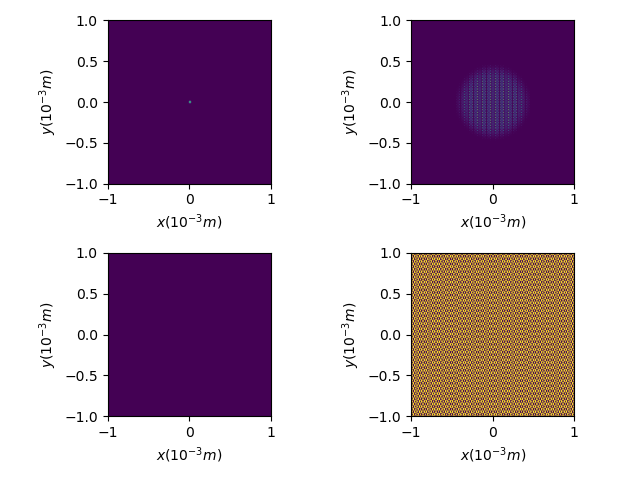

In [12]:
periodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=periodic_modulation_properties,
                           precision_control=periodic_precision,
                           store_config=periodic_storage,
                           )

periodic_input_fields.gen_fields(periodic_mesh,)

periodic_input_fields.plot_fields()

(-0.9999997518636554+0j) (1+0j)
(-0.9999997518636554+0j) (1+0j)


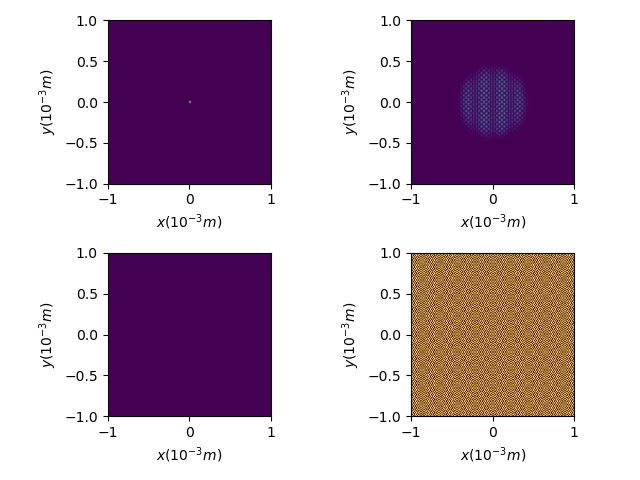

In [13]:
aperiodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=aperiodic_modulation_properties,
                           precision_control=aperiodic_precision,
                           store_config=aperiodic_storage,
                           )

aperiodic_input_fields.gen_fields(aperiodic_mesh,)

aperiodic_input_fields.plot_fields()

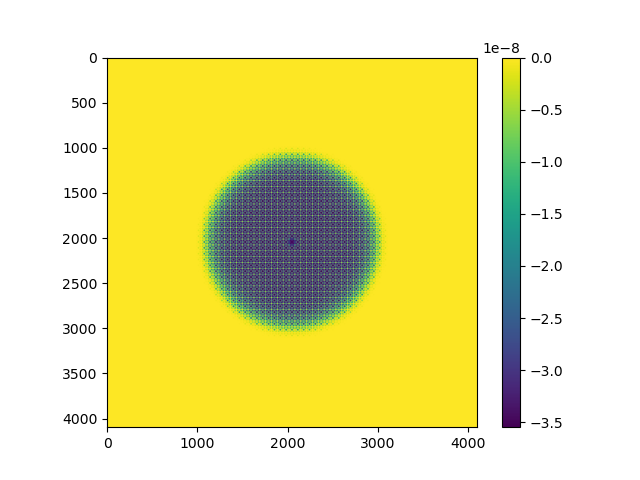

In [14]:
potential = periodic_coefs.potential_function(np.abs(periodic_input_fields.field)**2 + np.abs(periodic_input_fields.field1)**2)

potential /= periodic_mesh.adim_method.longitudinal_adim_factor
potential *= periodic_mesh.adim_method.transversal_adim_factor**2

fig, axs = plt.subplots(1)
im = axs.imshow(potential)

fig.colorbar(im, ax=axs)

fig.show()

In [15]:
# density measurement
print(np.sum(np.abs(periodic_input_fields.field1)**2*(simulation_config["lx"]/simulation_config["Nx"])*(simulation_config["ly"]/simulation_config["Ny"]))/(np.pi*(800e-6)**2), np.sum(np.abs(periodic_input_fields.field)**2*(simulation_config["lx"]/simulation_config["Nx"])*(simulation_config["ly"]/simulation_config["Ny"]))/(np.pi*(11e-6)**2))

np.sum(np.abs(aperiodic_input_fields.field1)**2*(simulation_config["lx"]/simulation_config["Nx"])*(simulation_config["ly"]/simulation_config["Ny"]))/(np.pi*(800e-6)**2), np.sum(np.abs(aperiodic_input_fields.field)**2*(simulation_config["lx"]/simulation_config["Nx"])*(simulation_config["ly"]/simulation_config["Ny"]))/(np.pi*(11e-6)**2)

0.21189340804386153 1.4493307216319606


(np.float64(0.21189369274177886), np.float64(1.4493307216319606))

In [16]:
print(f"State is between [{np.min(np.abs(periodic_input_fields.field)**2)}, {np.max(np.abs(periodic_input_fields.field)**2)}]")

print(f"Periodic Lattice is between [{np.min(np.abs(periodic_input_fields.field1)**2)}, {np.max(np.abs(periodic_input_fields.field1)**2)}]")

print(f"Aperiodic Lattice is between [{np.min(np.abs(aperiodic_input_fields.field1)**2)}, {np.max(np.abs(aperiodic_input_fields.field1)**2)}]")

area_cm2 = simulation_config["lx"]*10**2*simulation_config["ly"]*10**2

print(f"Periodic Average Intensity {np.sum(np.abs(periodic_input_fields.field1)*periodic_mesh.dx*periodic_mesh.dy)/area_cm2}; Aperiodic Average Intensity {np.sum(np.abs(aperiodic_input_fields.field1)*aperiodic_mesh.dx*aperiodic_mesh.dy)/area_cm2}")

area_state = np.pi*(20e-4)**2

print(f"Input Excitation Density {np.sum(np.abs(periodic_input_fields.field)*periodic_mesh.dx*periodic_mesh.dy)/(area_state)}")

State is between [0.0, 1.4486100891013785]
Periodic Lattice is between [0.0, 7.48437398613801]
Aperiodic Lattice is between [0.0, 7.440486768726087]
Periodic Average Intensity 443514.9296418398; Aperiodic Average Intensity 431577.878008247
Input Excitation Density 2963176.37999516


In [17]:
np.max(np.abs(aperiodic_input_fields.field)**2), np.max(np.abs(aperiodic_input_fields.field1)**2), np.max(np.abs(periodic_input_fields.field)**2), np.max(np.abs(periodic_input_fields.field1)**2)

(np.float64(1.4486100891013785),
 np.float64(7.440486768726087),
 np.float64(1.4486100891013785),
 np.float64(7.48437398613801))

In [18]:
periodic_SimBox.solver(periodic_input_fields, store_config=periodic_storage)

aperiodic_SimBox.solver(aperiodic_input_fields, store_config=aperiodic_storage)

e:\Vicente Rocha\PhD Thesis Project\Photonic-Crystals\Studies\PhotorefractiveCrystals\Localization in Moire Lattices\../../..\src\fields\field_plotting.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


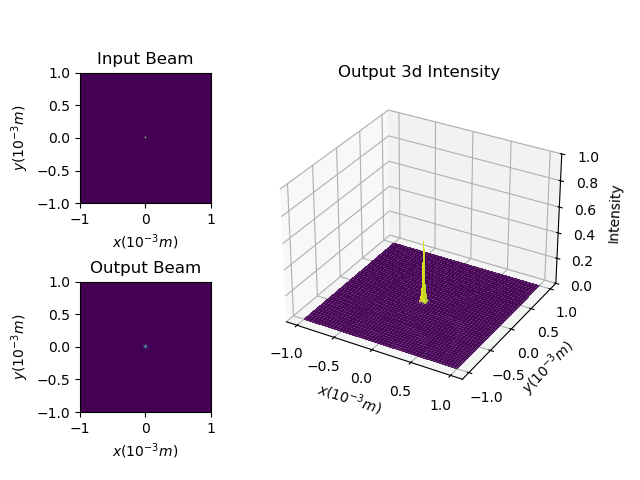

In [19]:
periodic_input_fields.plot_input_output_3d()

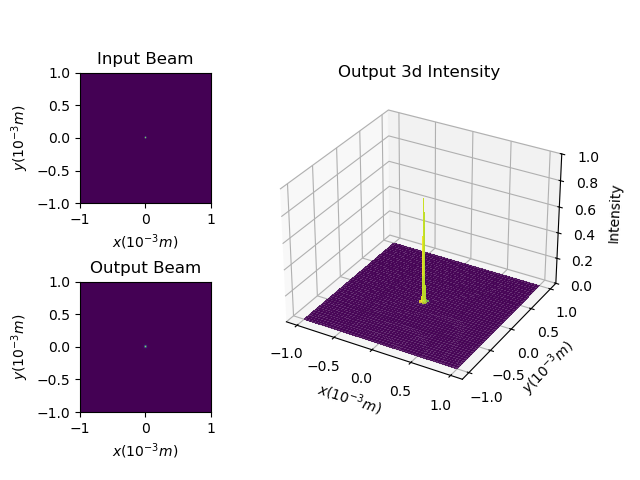

In [20]:
aperiodic_input_fields.plot_input_output_3d()

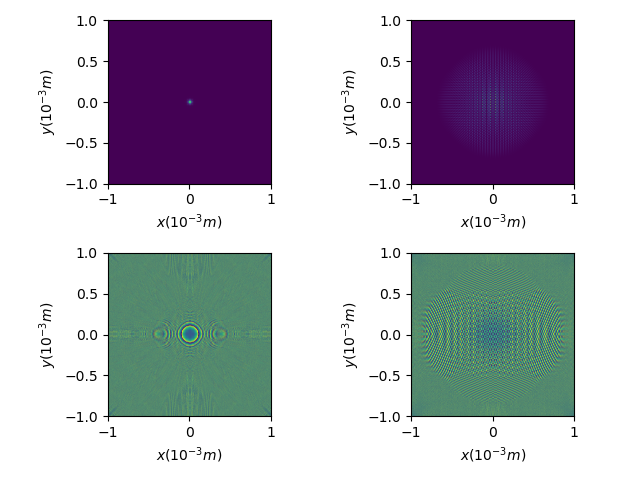

In [21]:
periodic_input_fields.plot_fields()

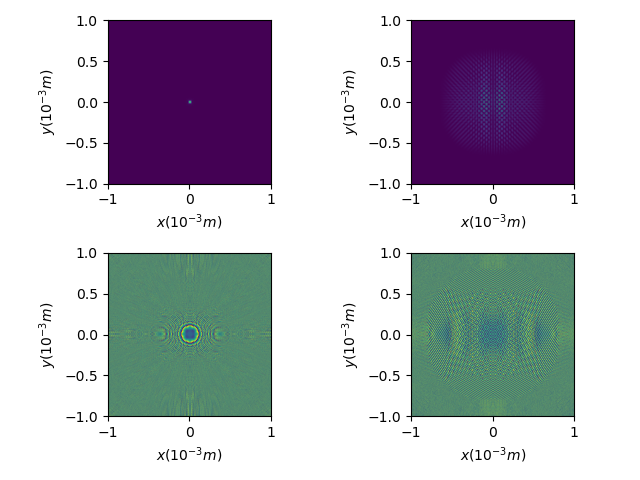

In [22]:
aperiodic_input_fields.plot_fields()